In [43]:
# Fix randomness and hide warnings
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
from scipy.fft import fft
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas import Series
from sklearn.model_selection import train_test_split
import seaborn as sns
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
# Load Data

categories = np.load("training_dataset/categories.npy")
training_data = np.load("training_dataset/training_data.npy")
valid_periods = np.load("training_dataset/valid_periods.npy")

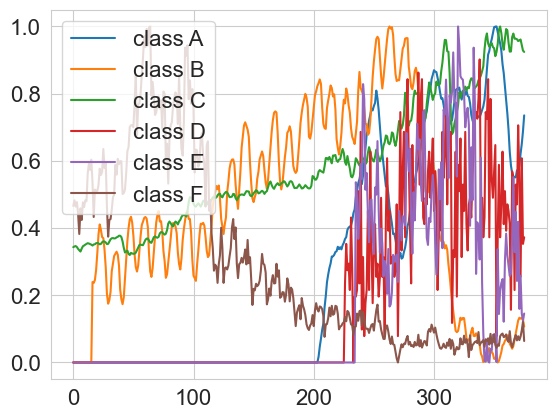

In [3]:
# Visualize one timeseries example for each class in the dataset.

plt.figure()
for c in np.unique(categories):
    c_x_train = training_data[categories == c]
    plt.plot(c_x_train[random.randrange(len(c_x_train))][2400:], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

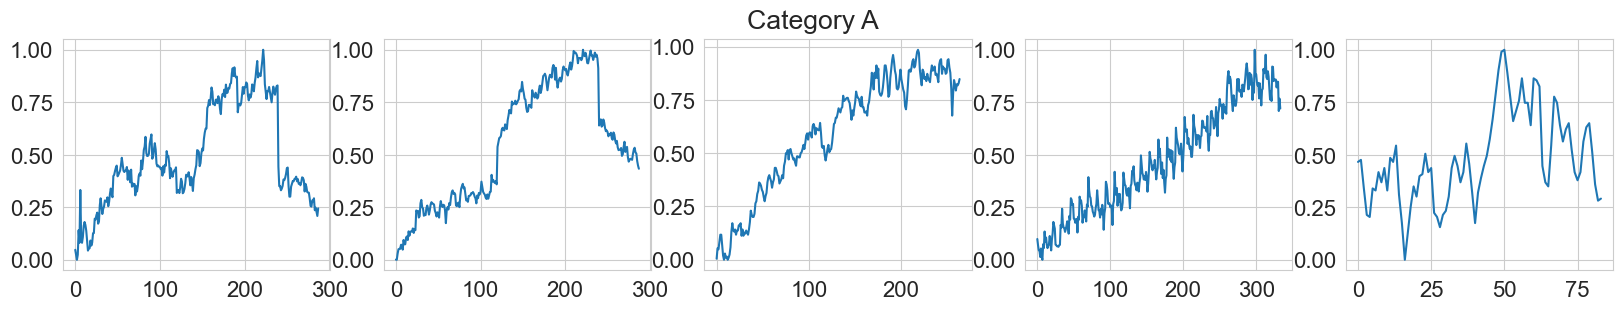

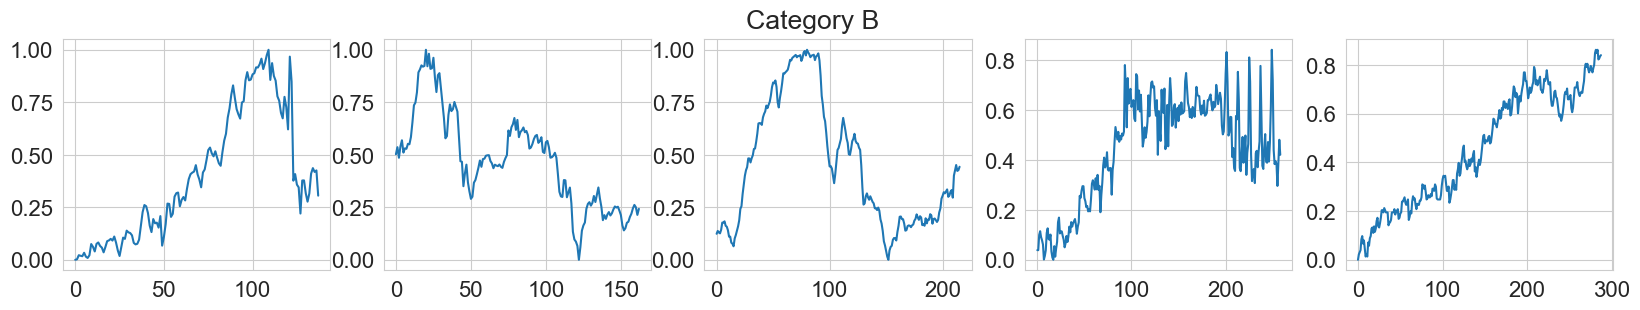

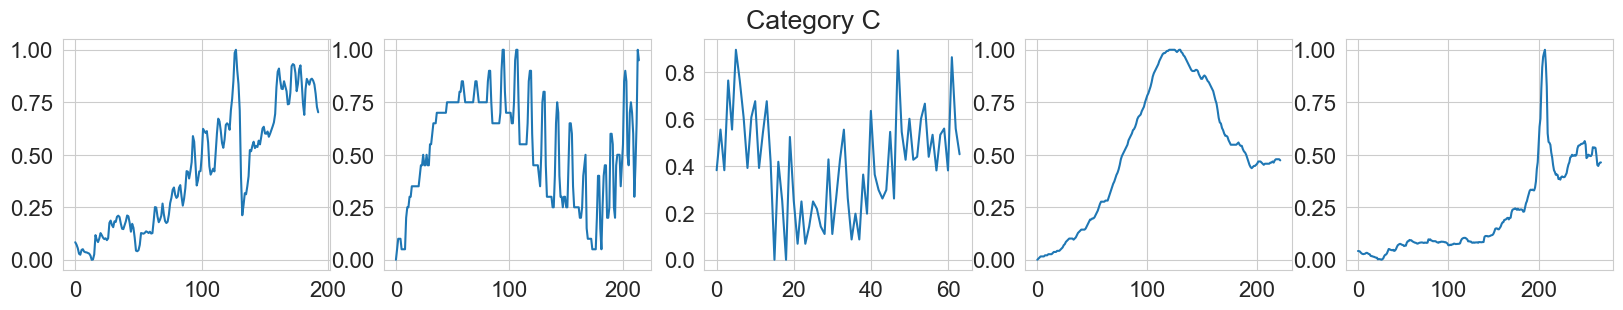

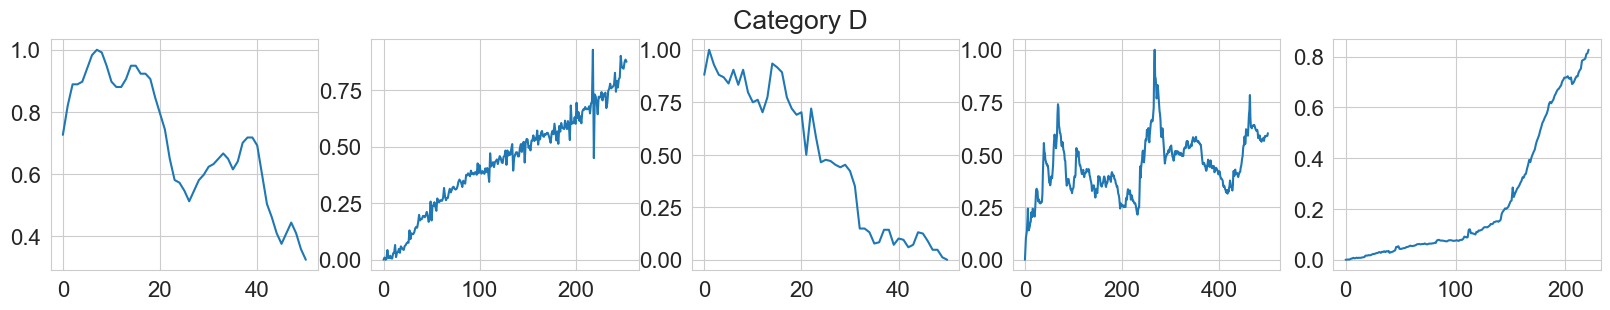

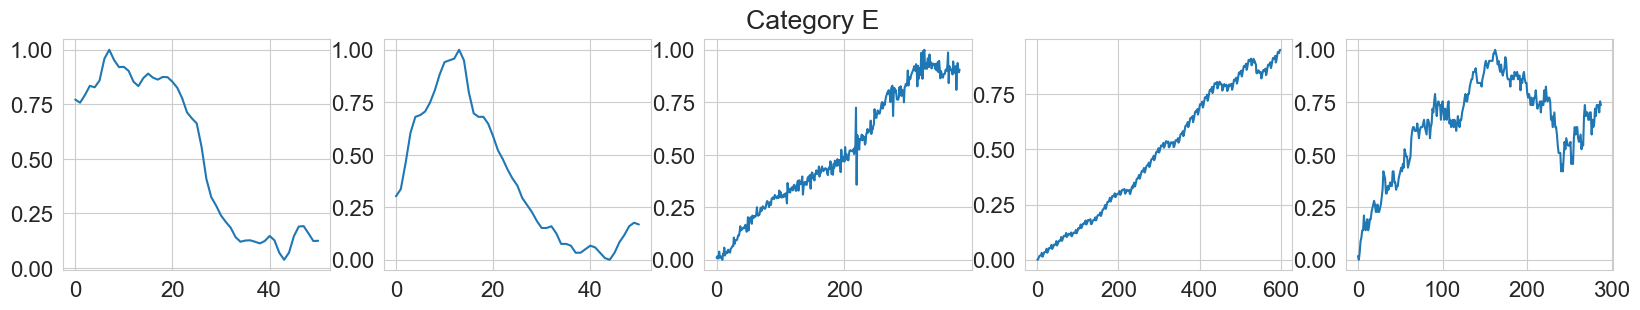

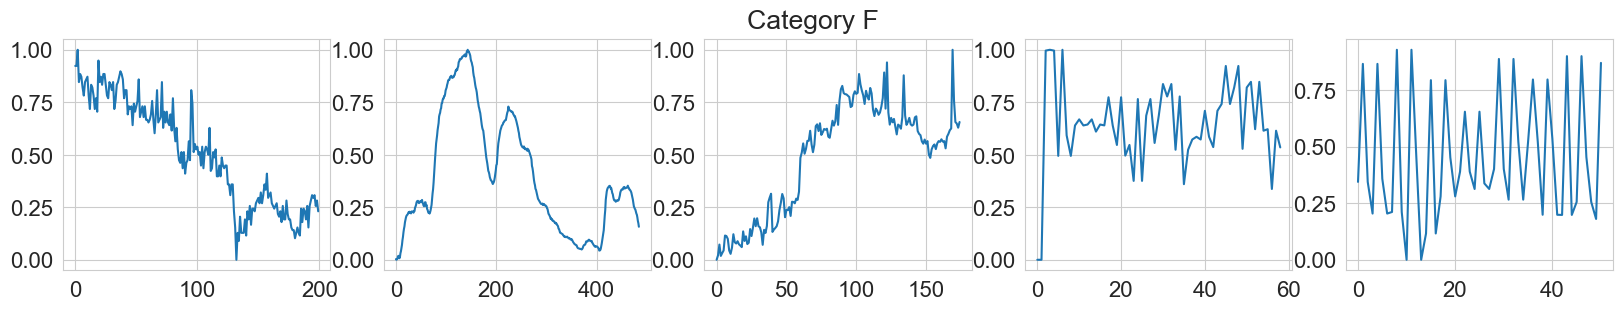

In [4]:
# Visualize some timeseries example for each class

for c in np.unique(categories):
    n_samples = 5
    fig, axs = plt.subplots(1, n_samples, figsize=(20, 3))
    timeseries = training_data[categories==c]
    periods = valid_periods[categories==c]
    fig.suptitle("Category " + c)
    for i in range(n_samples):
        index = random.randrange(len(timeseries))
        axs[i].plot(timeseries[index][periods[index, 0] : periods[index, 1]])
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

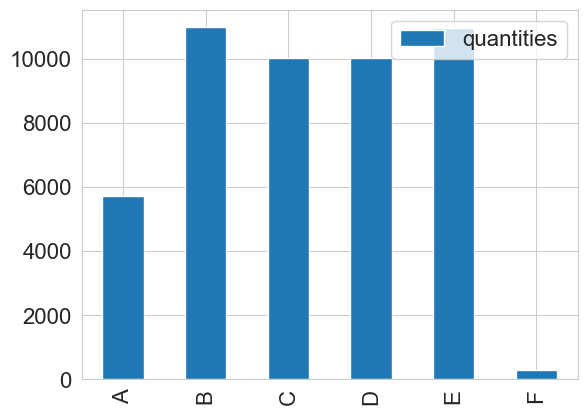

   quantities
A        5728
B       10987
C       10017
D       10016
E       10975
F         277


In [5]:
# Classes and quantities

classes, quantities = np.unique(categories, return_counts=True)
quantities = pd.DataFrame(quantities, index=classes, columns=['quantities'])
plt.figure()
quantities.plot(kind='bar')
plt.show()
plt.close()
print(quantities)

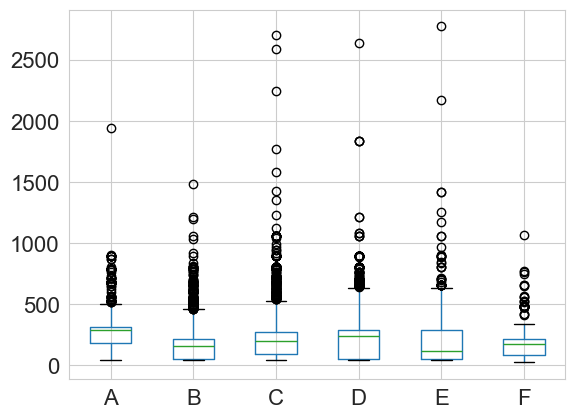

In [6]:
# Durations

plt.figure()
durations = pd.DataFrame()
for c in np.unique(categories):
    dur = pd.DataFrame(valid_periods[categories == c, 1] - valid_periods[categories == c, 0], columns=[c])
    durations = pd.concat([durations, dur], axis=1)
durations.boxplot()
plt.show()
plt.close()

In [64]:
def findMaxLocalMaxima(ts):
    localMax = np.min(ts)
    maxIndex = 0
    for i in range(1, len(ts) - 1):
        prev = ts[i-1]
        curr = ts[i]
        next = ts[i+1]
        if curr > prev and curr > next and curr > localMax:
            localMax = curr
            maxIndex = i
    return None if maxIndex is 0 else maxIndex

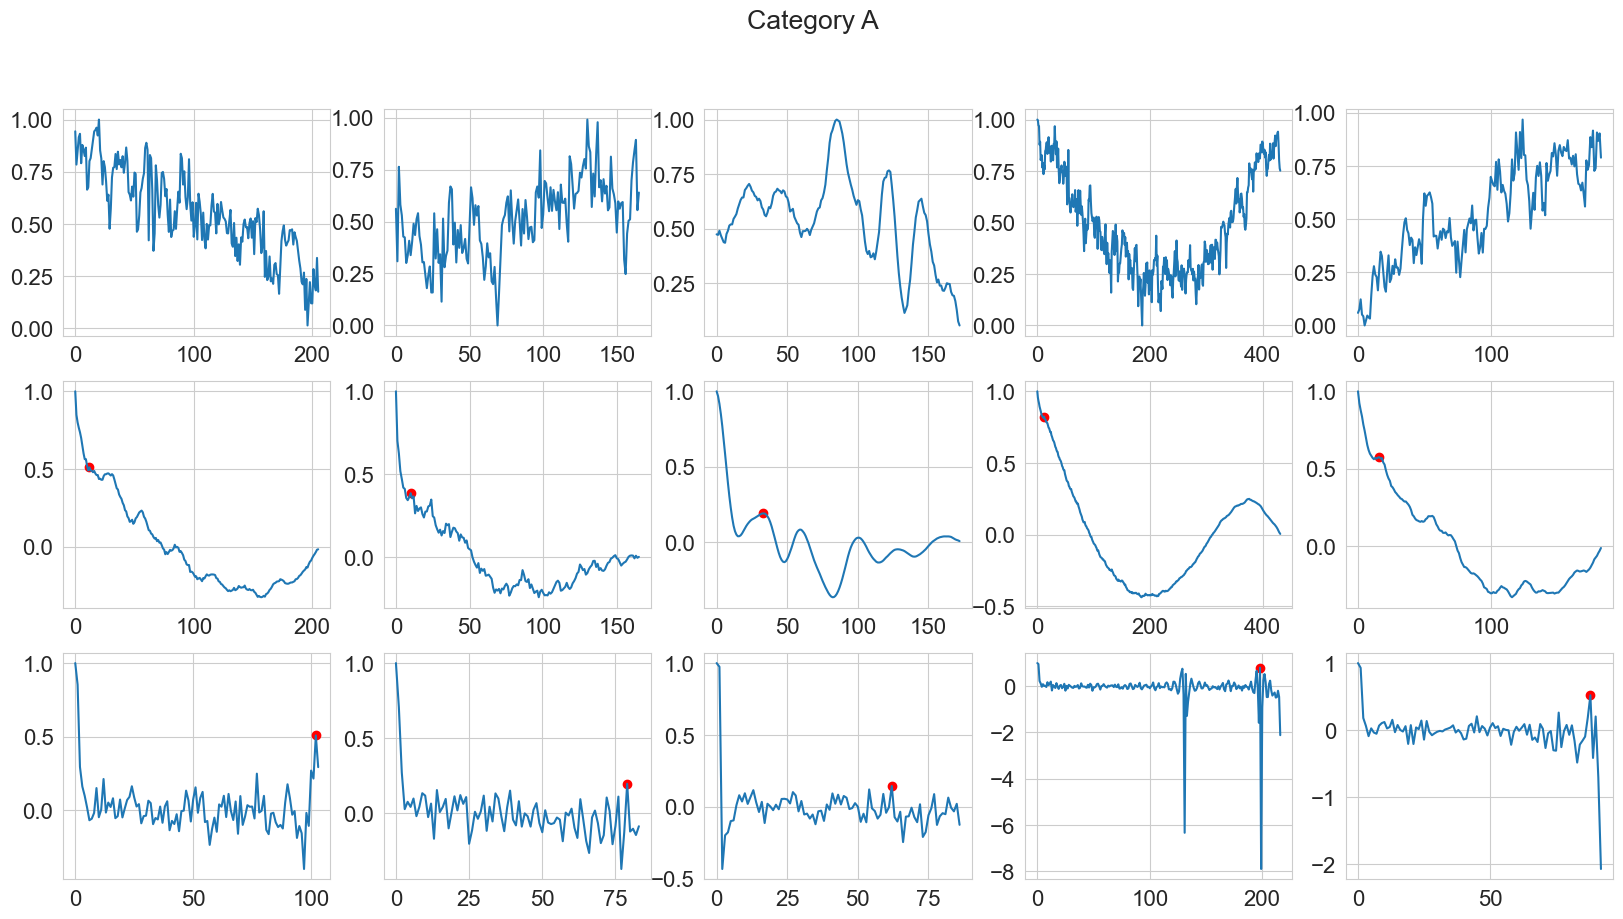

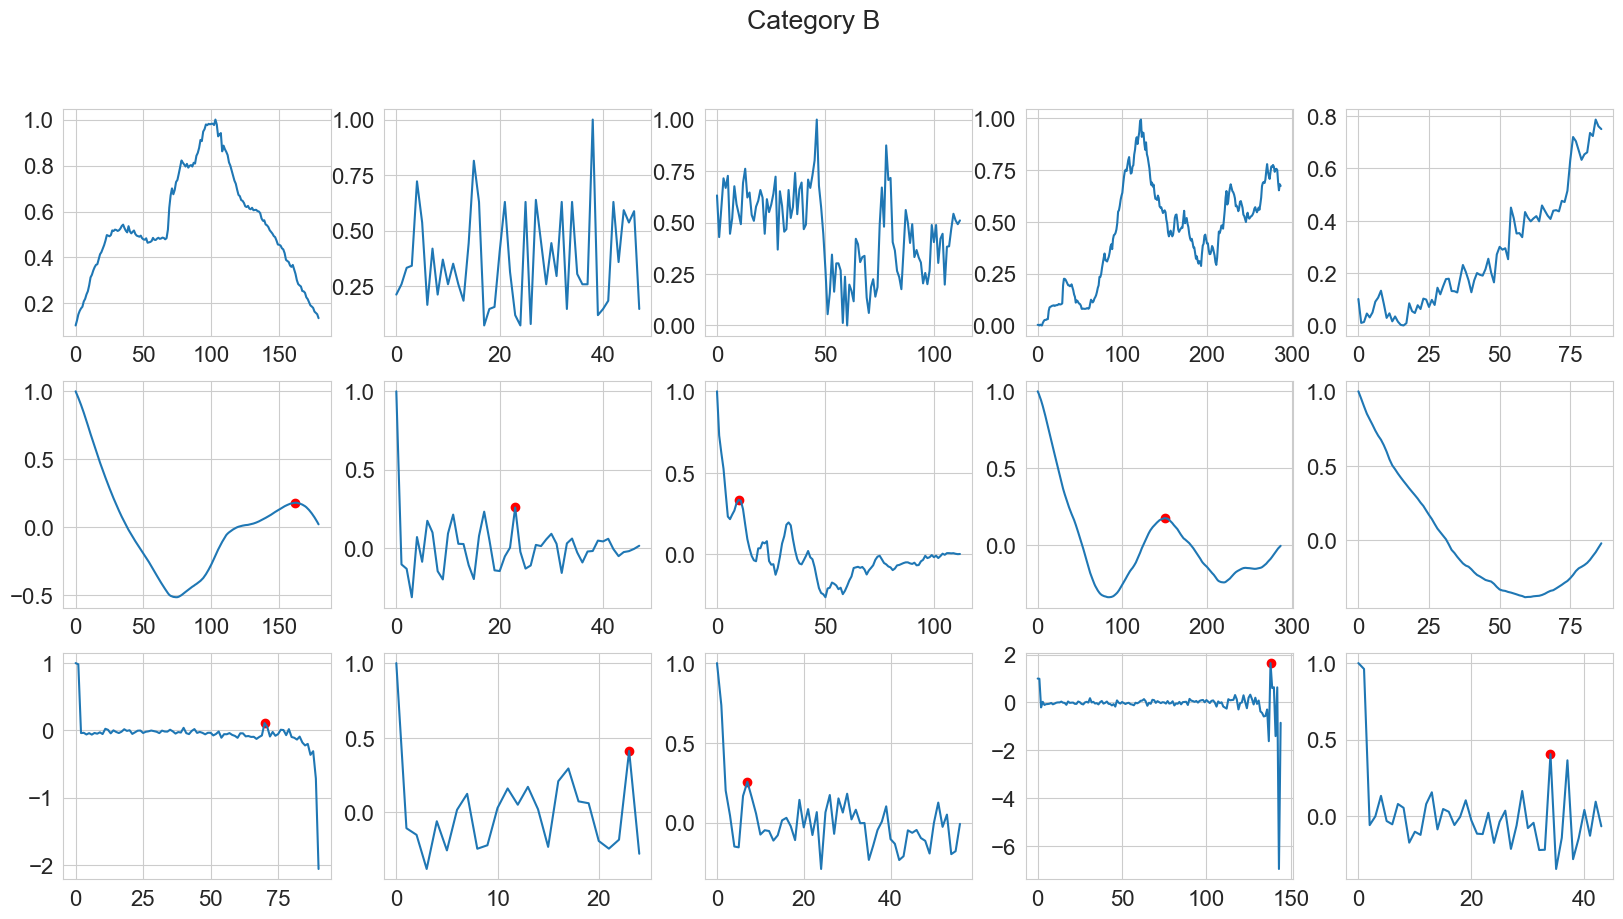

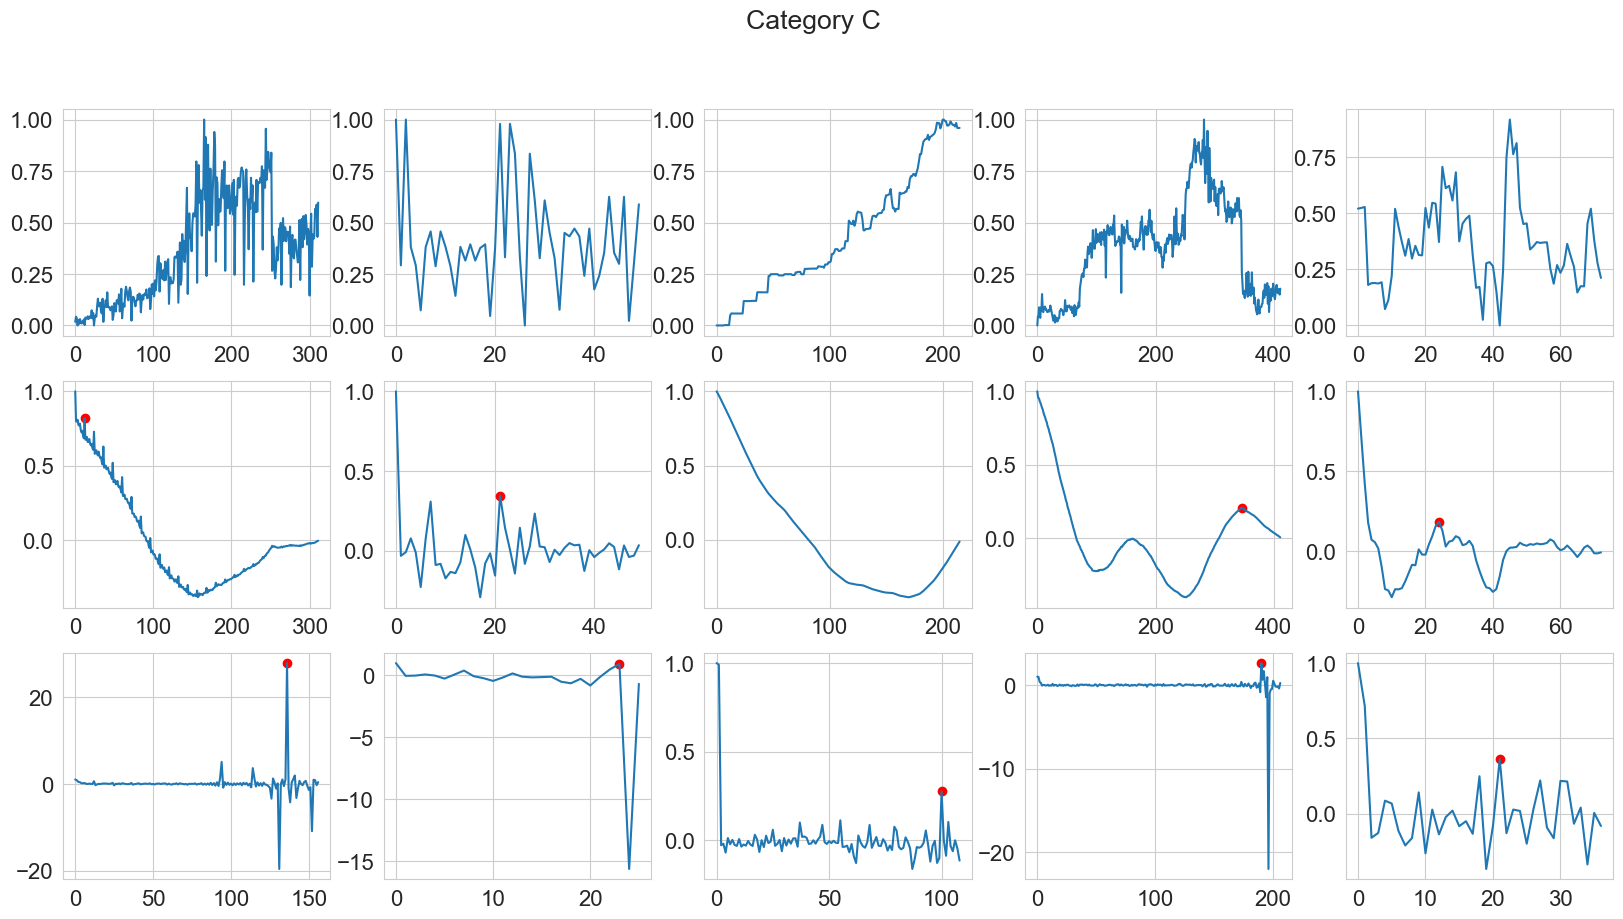

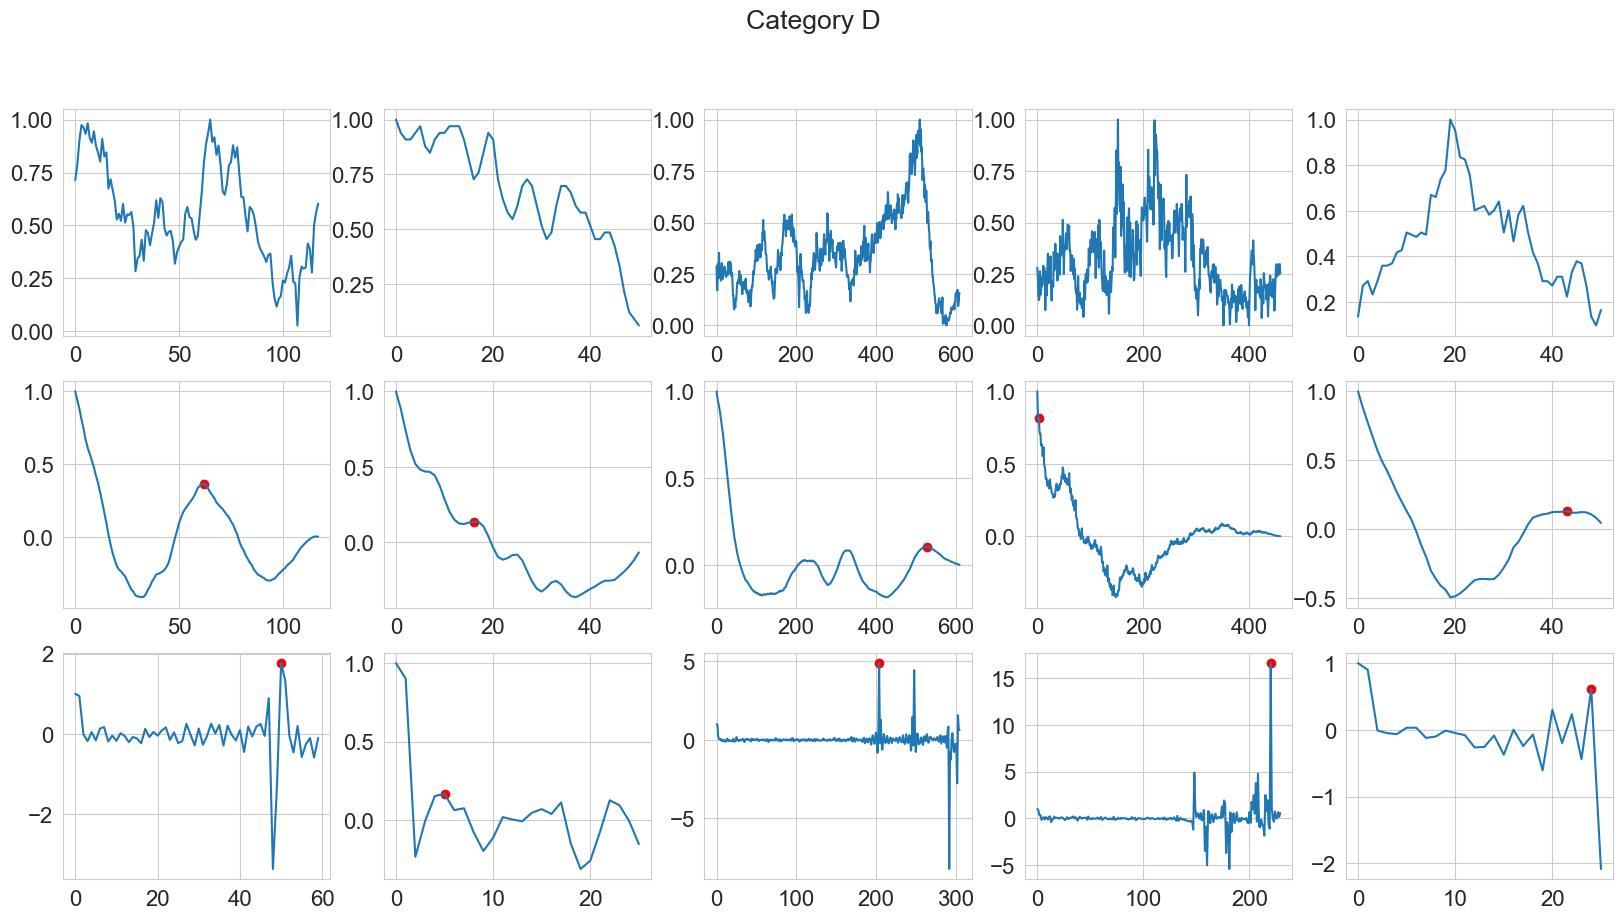

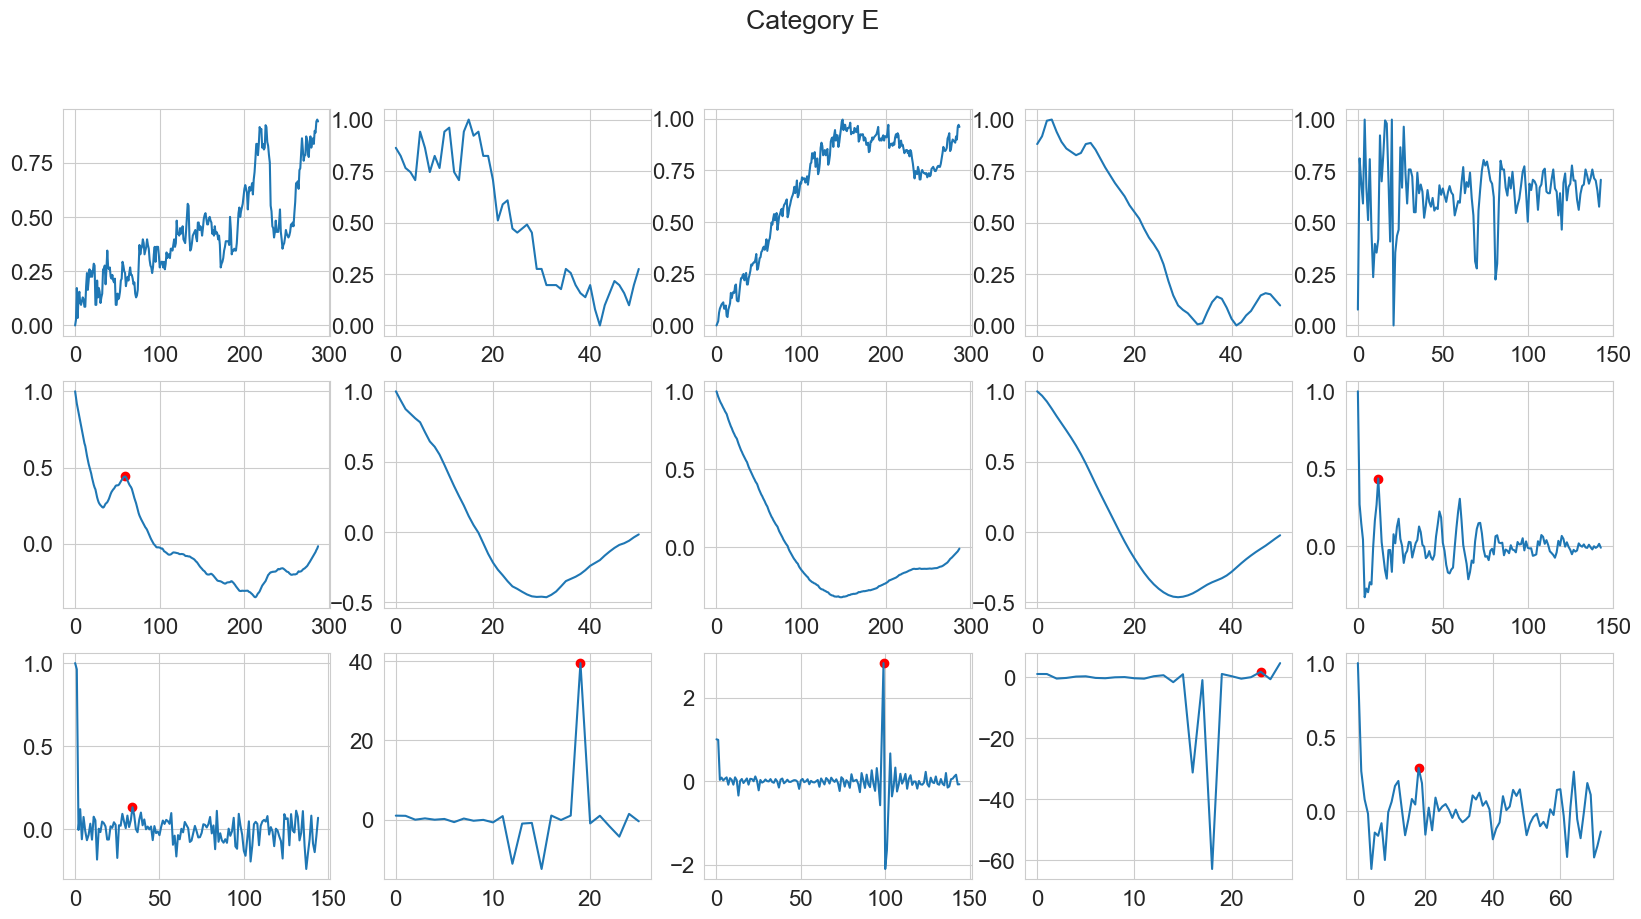

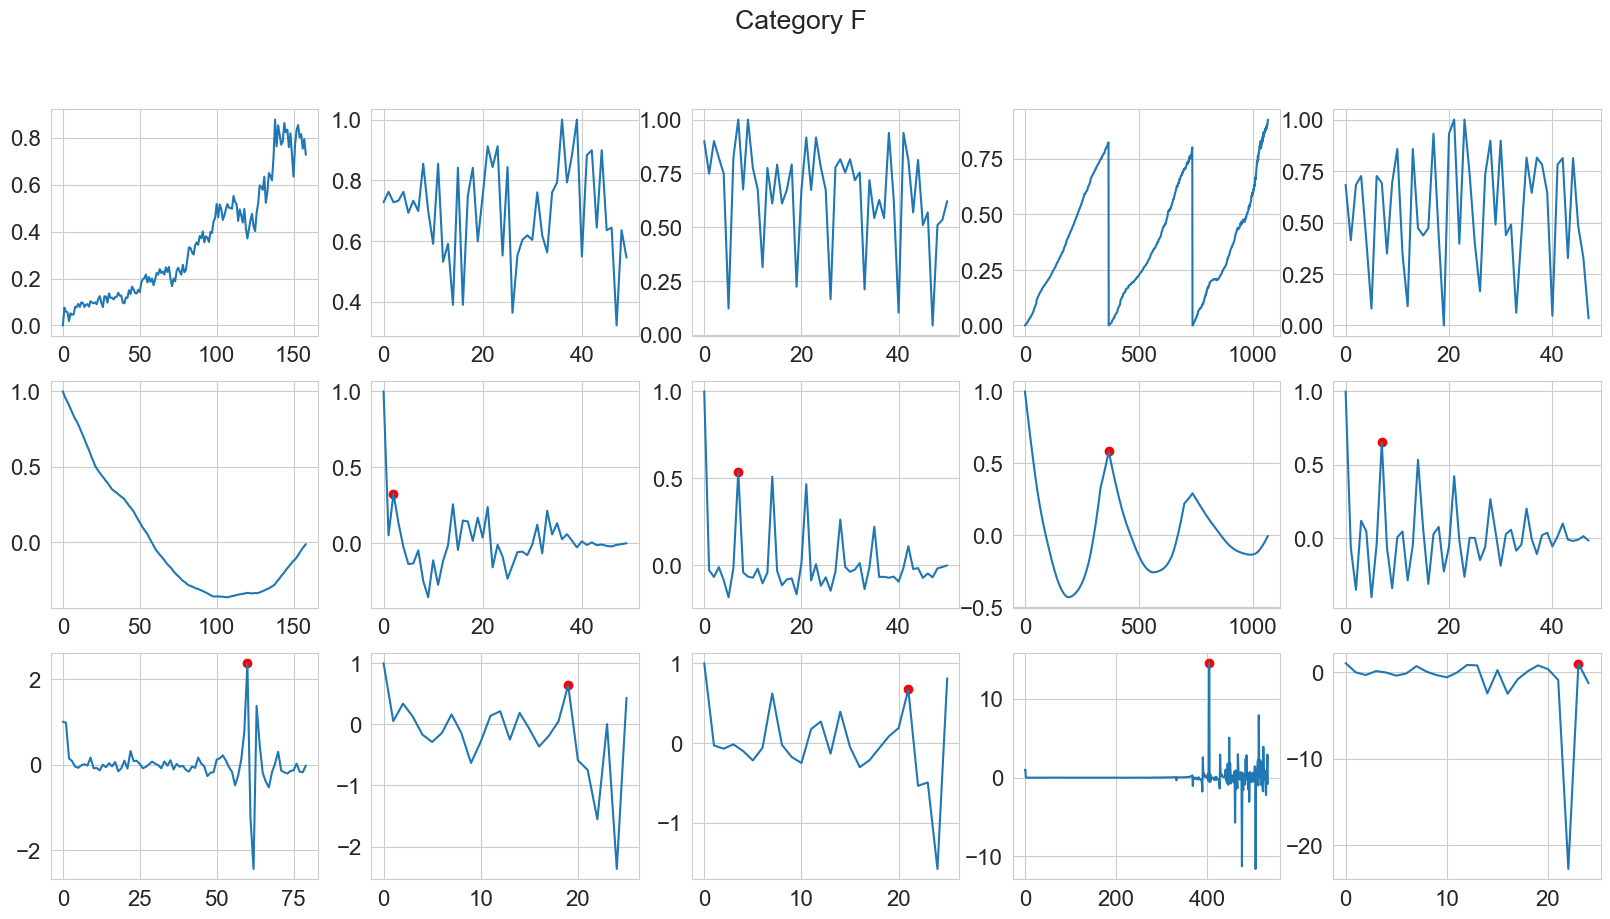

In [59]:
# Autocorrelation

for c in np.unique(categories):
    n_samples = 5
    fig, axs = plt.subplots(3, n_samples, figsize=(20, 10))
    timeseries = training_data[categories==c]
    periods = valid_periods[categories==c]
    fig.suptitle("Category " + c)
    for i in range(n_samples):
        index = random.randrange(len(timeseries))
        ts = timeseries[index][periods[index, 0] : periods[index, 1]]
        ac = acf(ts, nlags=len(ts))
        pac = pacf(ts, nlags=len(ts)//2)
        estimatedWindow_ac = findMaxLocalMaxima(ac)
        estimatedWindow_pac = findMaxLocalMaxima(pac)
        axs[0, i].plot(ts) 
        axs[1, i].plot(ac)
        if estimatedWindow_ac is not None:
            axs[1, i].scatter([estimatedWindow_ac], [ac[estimatedWindow_ac]], color="red")
        axs[2, i].plot(pac)
        if estimatedWindow_pac is not None:
            axs[2, i].scatter([estimatedWindow_pac], [pac[estimatedWindow_pac]], color="red")
    plt.show()
    plt.close()

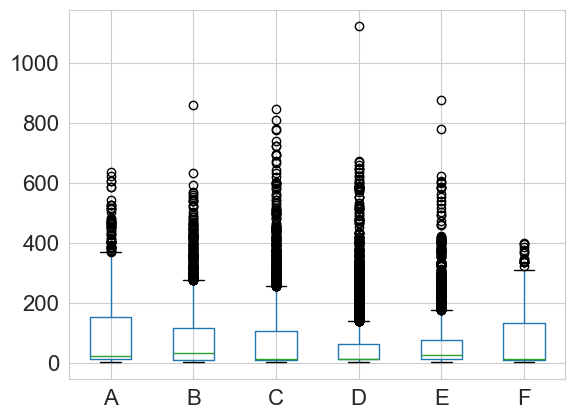

Number of timeseries with valid window size:
   total  valid  not valid          %
A   5728   5479        249   4.347067
B  10987   9497       1490  13.561482
C  10017   9003       1014  10.122791
D  10016   8407       1609  16.064297
E  10975   8837       2138  19.480638
F    277    238         39  14.079422
Autocorrelation window size for category :
        mean  median         std
A  85.276693    24.0  101.301983
B  68.707592    33.0   81.084063
C  66.073642    14.0   89.861765
D  61.581420    12.0   90.978142
E  63.949757    28.0   82.321075
F  80.630252    14.0  107.603850


In [72]:
# Window size inference with autocorrelation
plt.figure()
auto_windowSizes = pd.DataFrame()
for c in np.unique(categories):
    timeseries = training_data[categories==c]
    periods = valid_periods[categories==c]
    ws = []
    for ts, p in zip(timeseries, periods):
        ac = acf(ts[p[0]:p[1]], nlags=len(ts))
        ws.append(findMaxLocalMaxima(ac))
    ws = pd.DataFrame(ws, columns=[c])
    auto_windowSizes = pd.concat([auto_windowSizes, ws], axis=1)
auto_windowSizes.boxplot()
plt.show()
plt.close()

print("Number of timeseries with valid window size:")
n_notValid = pd.concat([quantities, auto_windowSizes.count()], axis=1)
n_notValid.columns = ['total', 'valid']
n_notValid['not valid'] = n_notValid['total'] - n_notValid['valid']
n_notValid['%'] = n_notValid['not valid'] / n_notValid['total'] * 100
print(n_notValid)

auto_results = pd.DataFrame()
auto_results['mean'] = auto_windowSizes.mean()
auto_results['median'] = auto_windowSizes.median()
auto_results['std'] = auto_windowSizes.std()
print("Autocorrelation window size for category :")
print(auto_results)

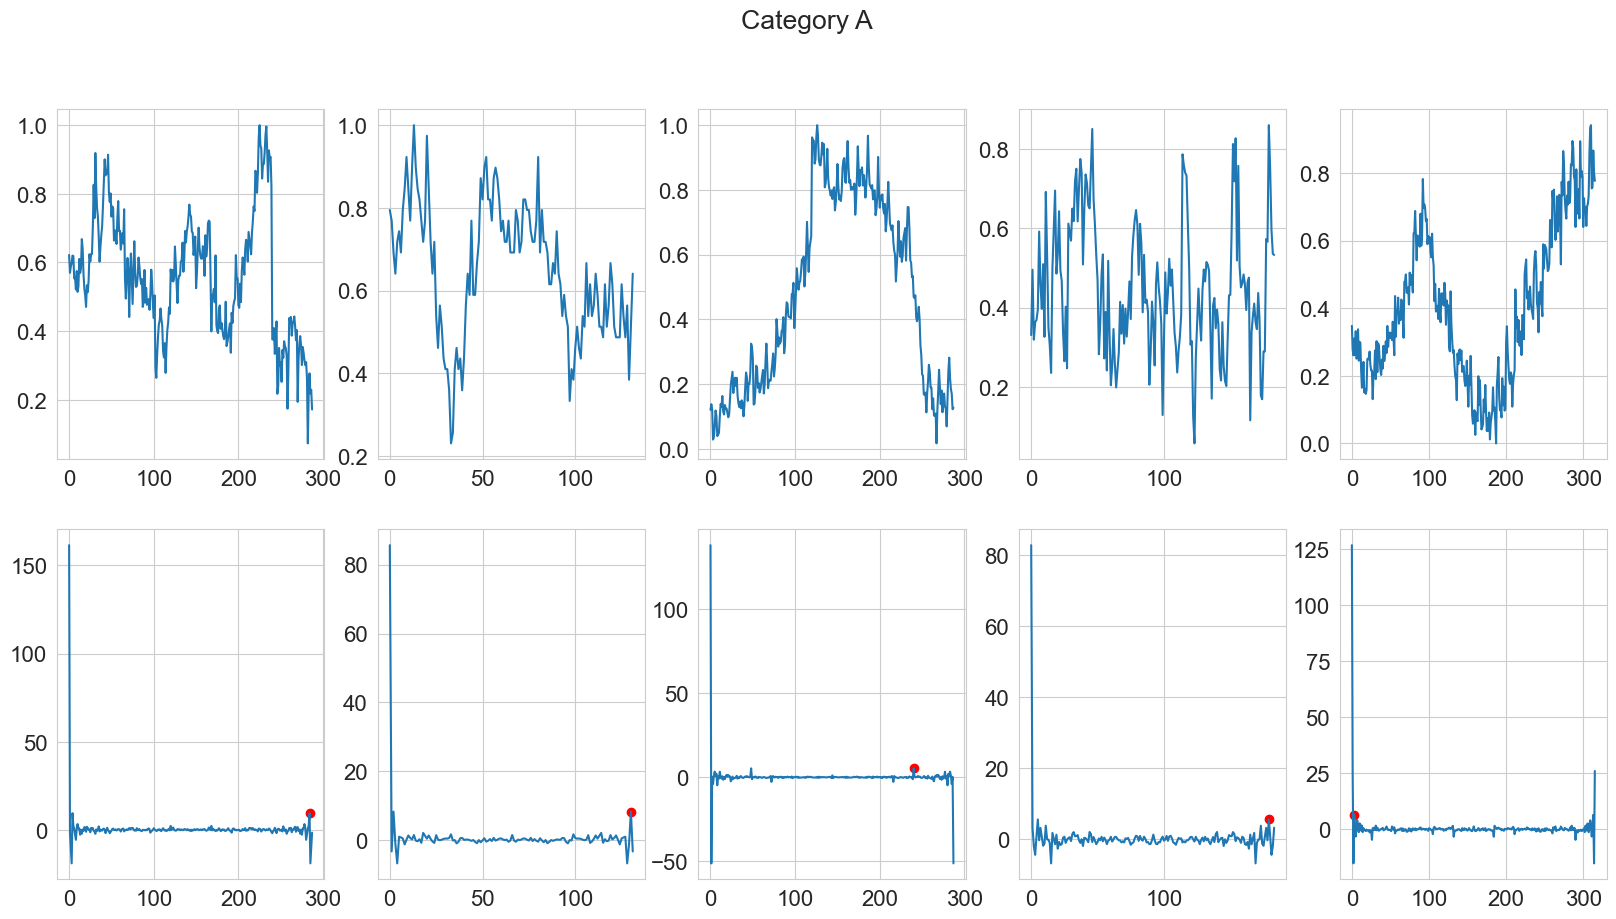

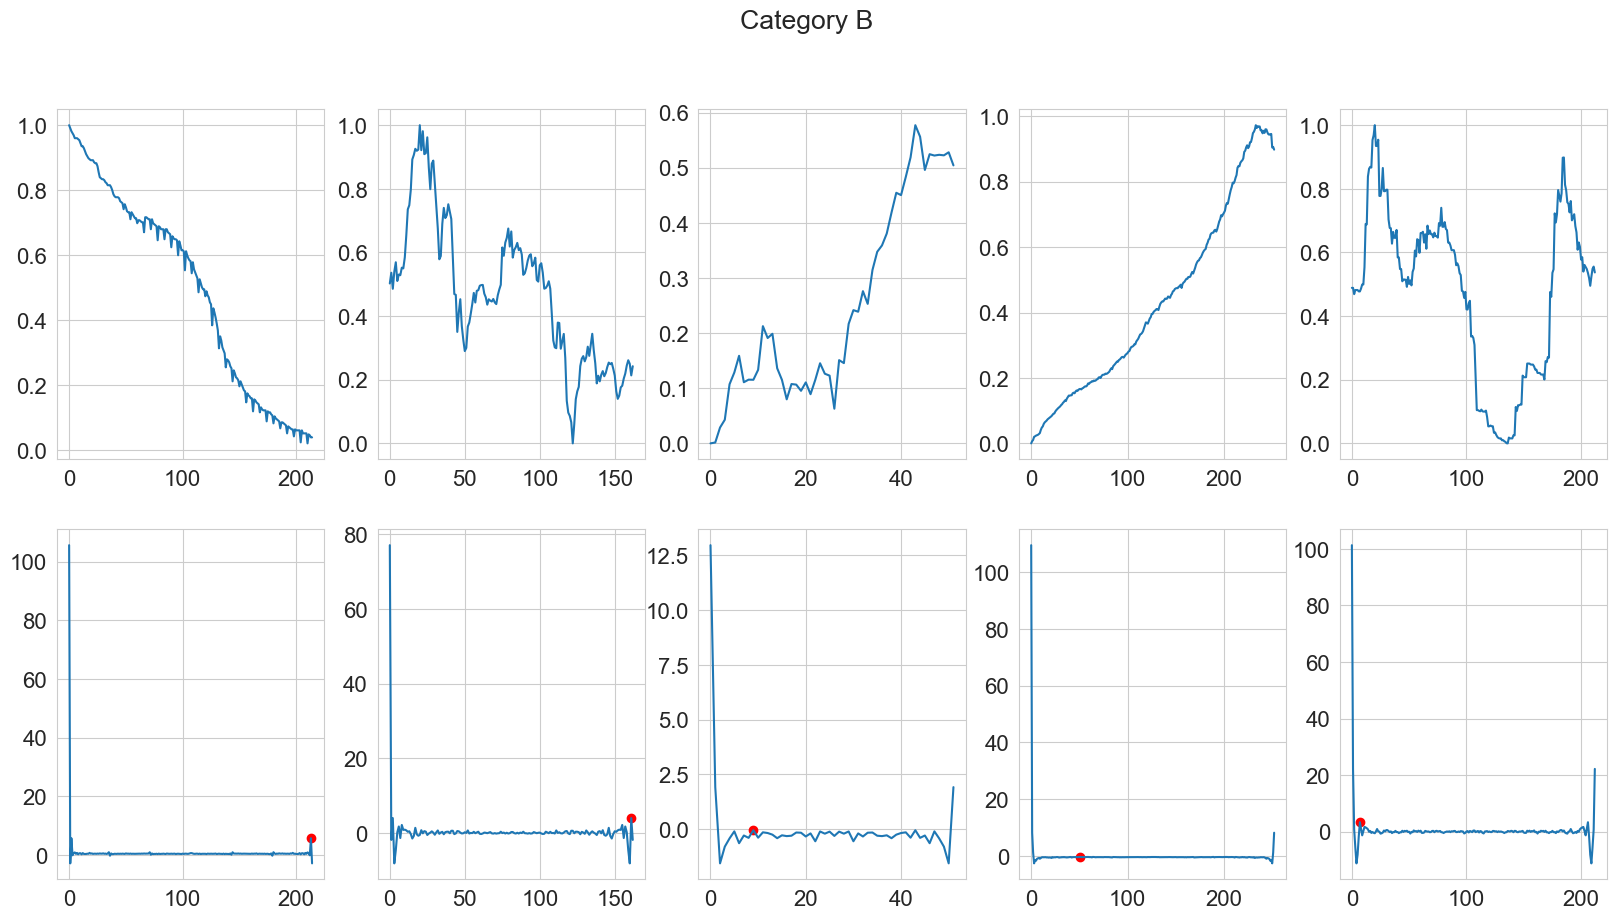

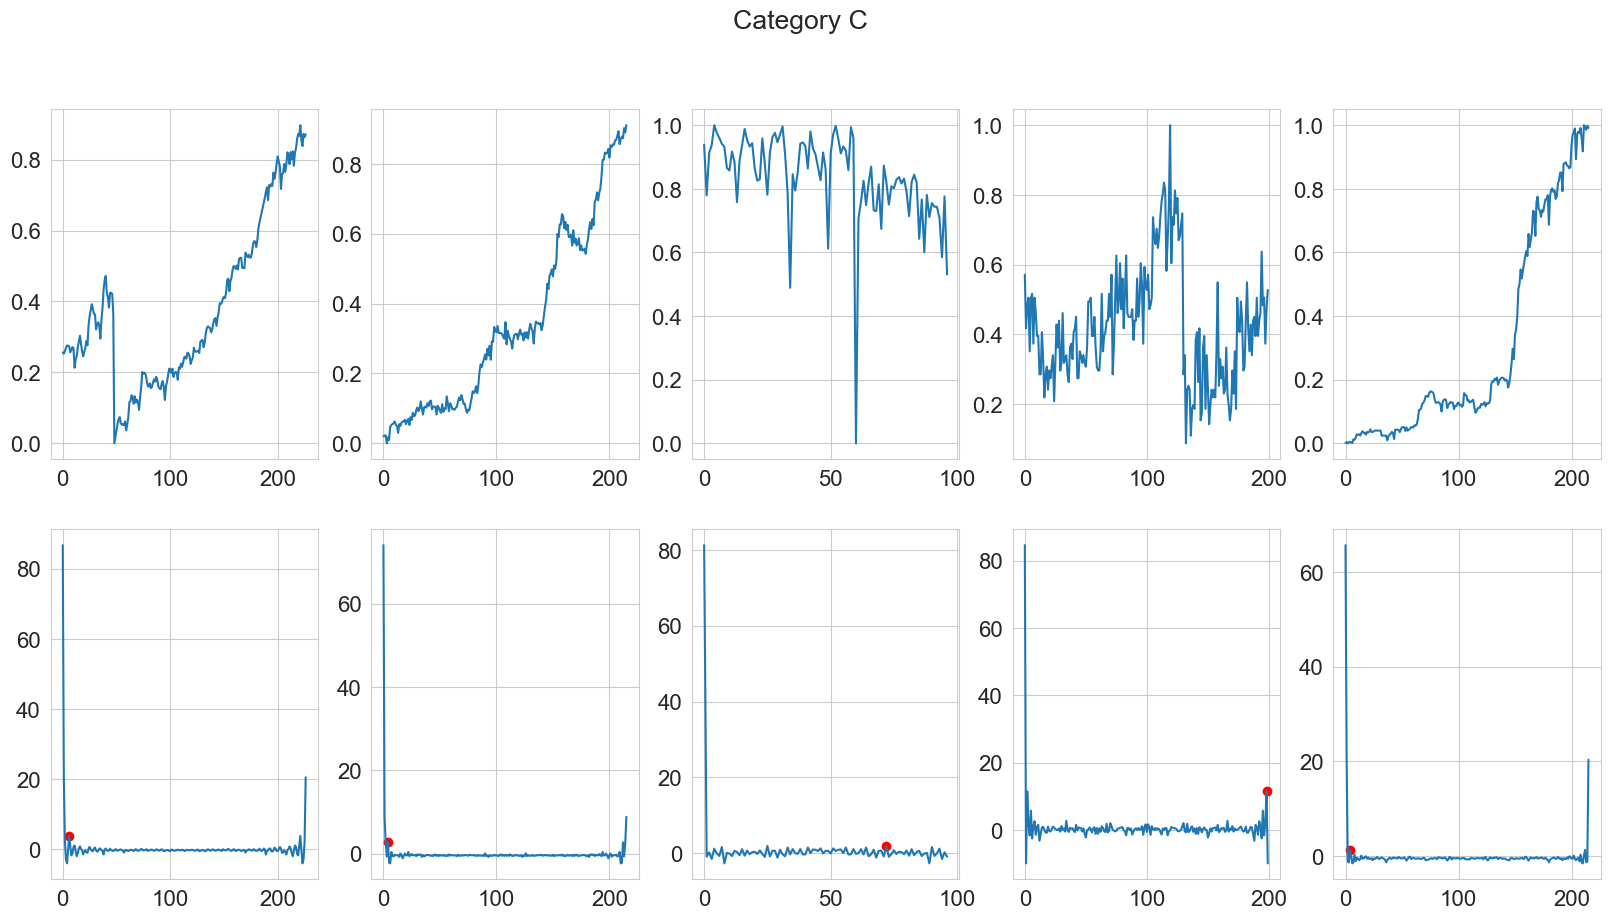

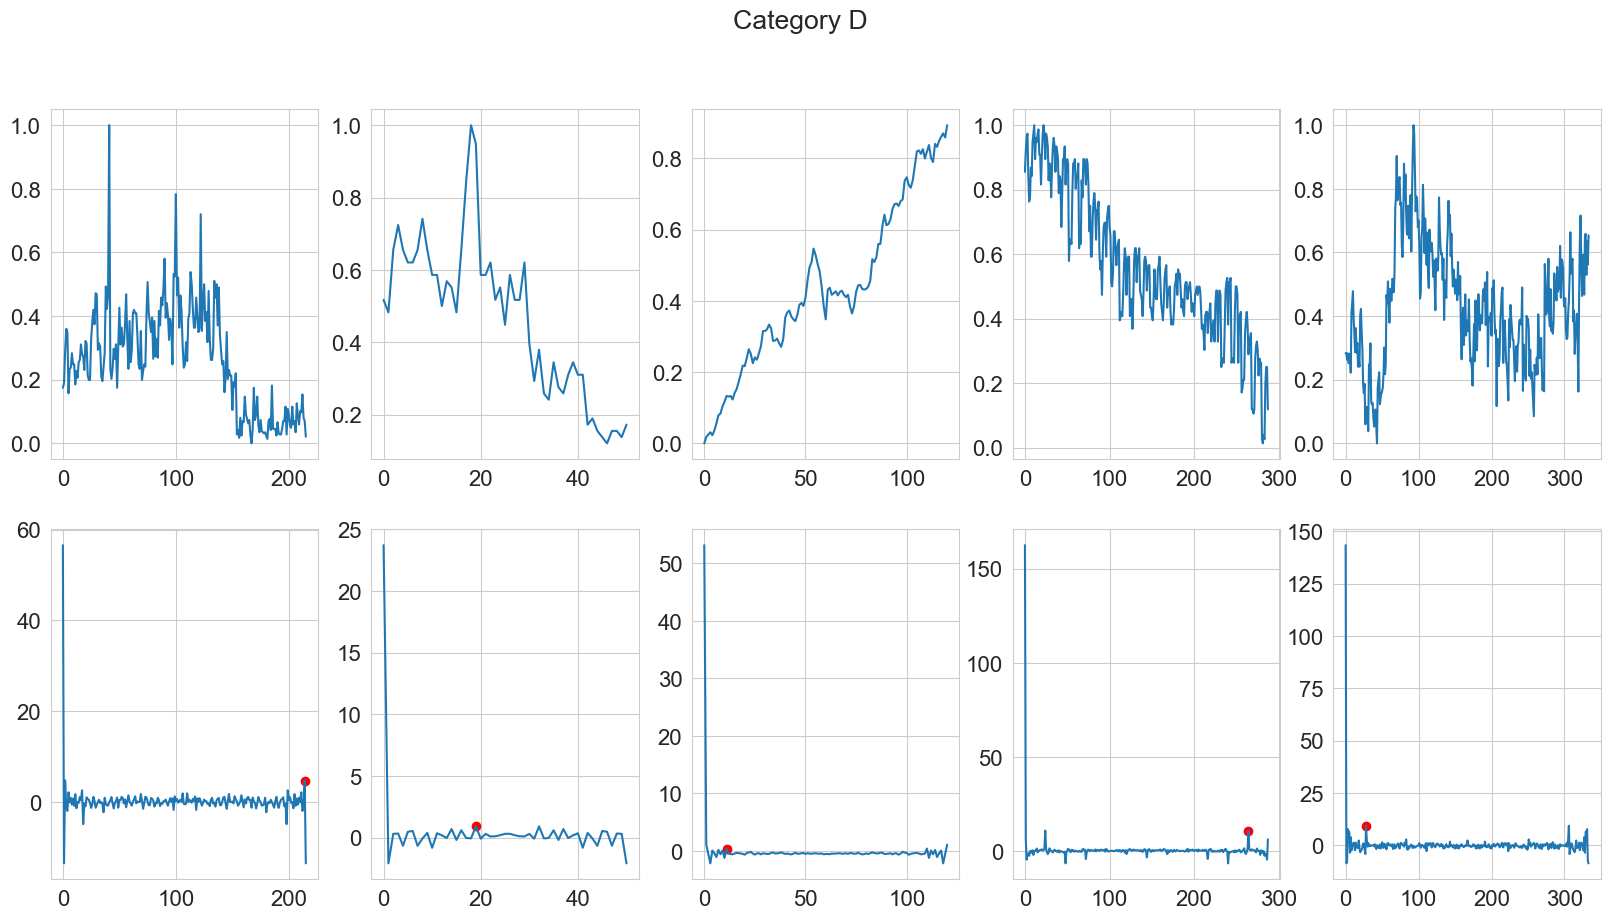

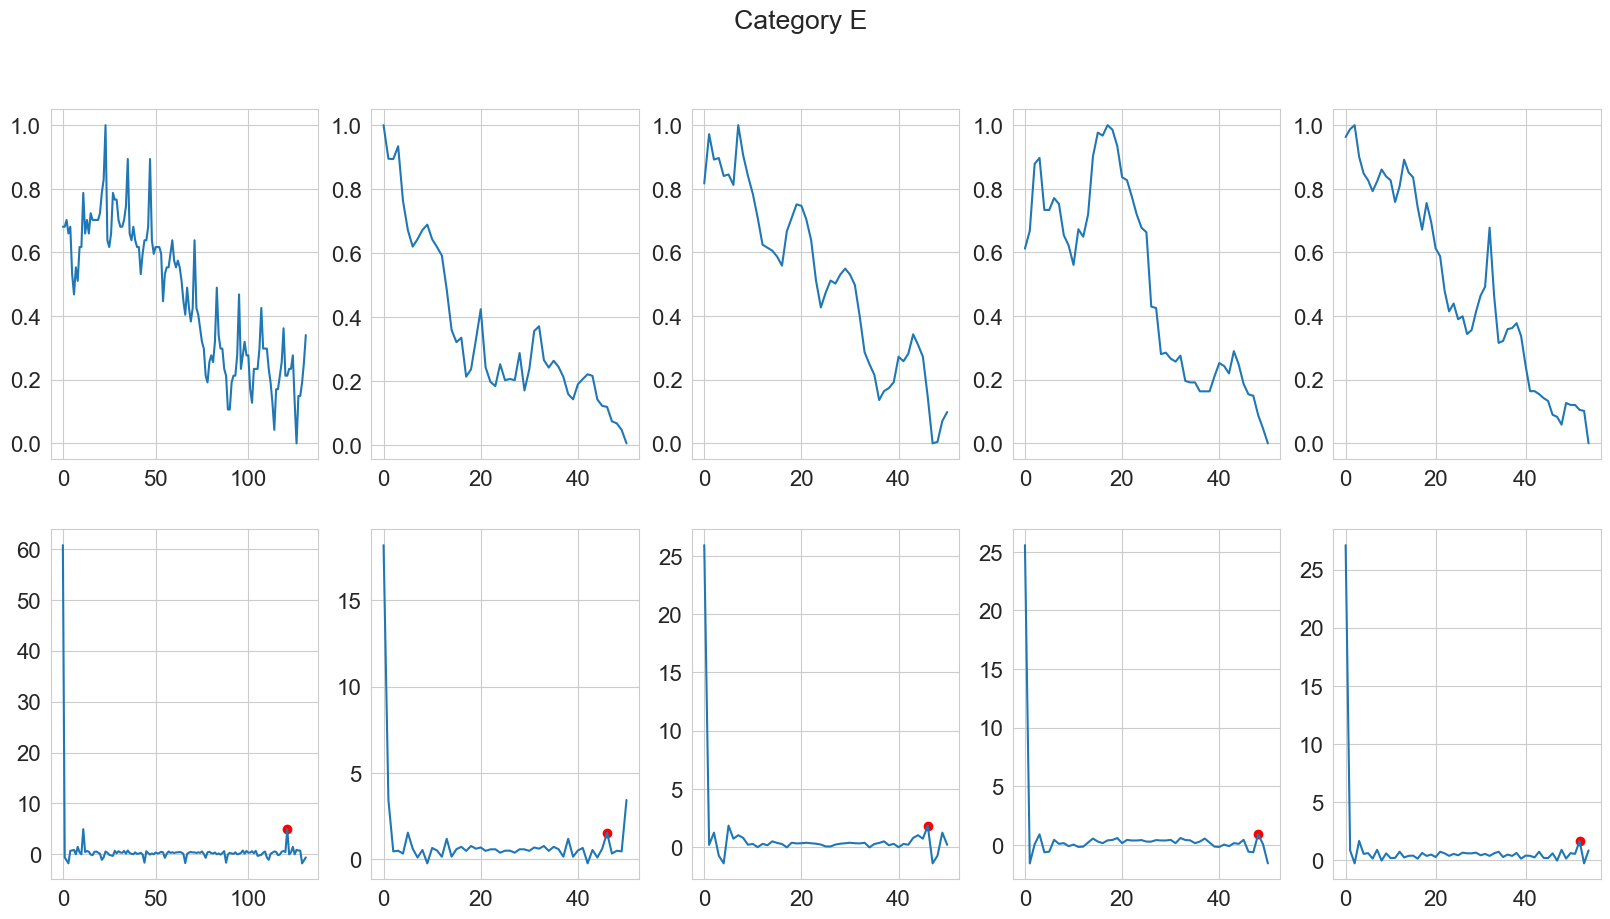

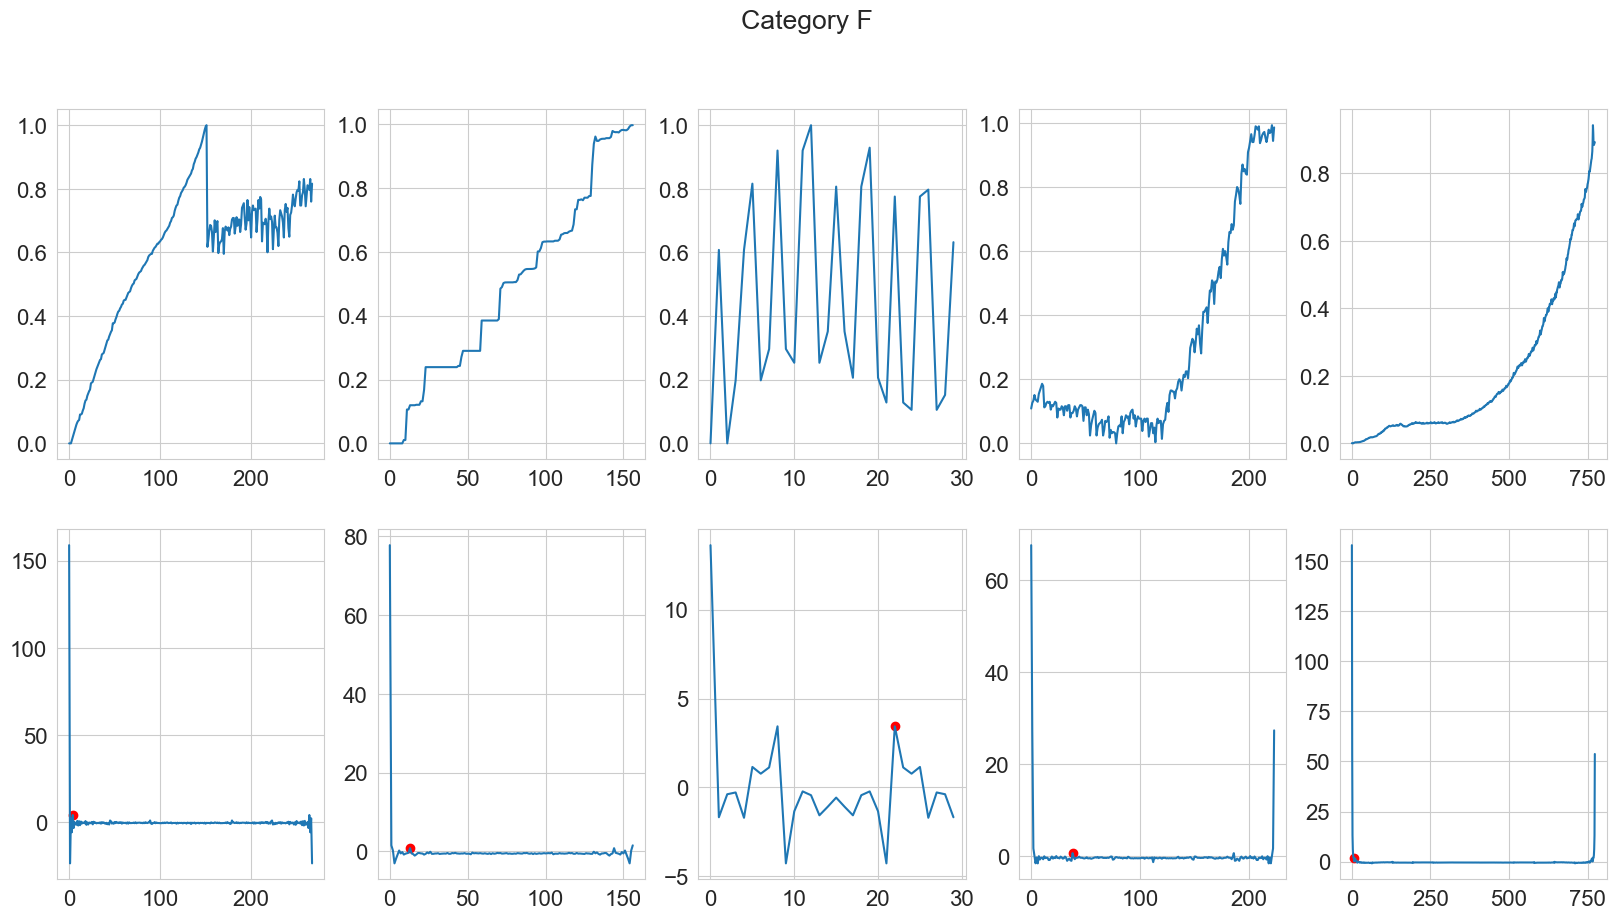

In [66]:
# Fourier Transformation

for c in np.unique(categories):
    n_samples = 5
    fig, axs = plt.subplots(2, n_samples, figsize=(20, 10))
    timeseries = training_data[categories==c]
    periods = valid_periods[categories==c]
    fig.suptitle("Category " + c)
    for i in range(n_samples):
        index = random.randrange(len(timeseries))
        ts = timeseries[index][periods[index, 0] : periods[index, 1]]
        fourier = fft(ts)
        estimatedWindow = findMaxLocalMaxima(fourier)
        axs[0, i].plot(ts)
        axs[1, i].plot(fourier)
        if estimatedWindow is not None:
            axs[1, i].scatter([estimatedWindow], [fourier[estimatedWindow]], color="red")
    plt.show()
    plt.close()

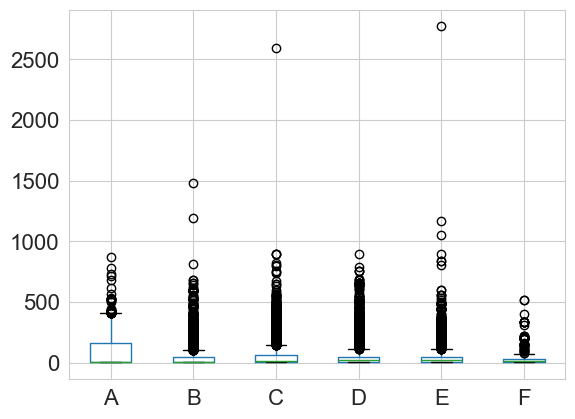

Number of timeseries with valid window size:
   total  valid  not valid         %
A   5728   5728          0  0.000000
B  10987  10986          1  0.009102
C  10017  10017          0  0.000000
D  10016  10016          0  0.000000
E  10975  10975          0  0.000000
F    277    277          0  0.000000
Fourier window size for category :
        mean  median         std
A  83.442214    10.0  116.897790
B  46.699709     9.0   83.206253
C  63.478387    15.0  105.798208
D  68.191294    24.0  104.726306
E  52.912073    26.0   88.255185
F  45.707581    11.0   85.551394


In [71]:
# Window size inference with fourier transform
plt.figure()
fourier_windowSizes = pd.DataFrame()
for c in np.unique(categories):
    timeseries = training_data[categories==c]
    periods = valid_periods[categories==c]
    ws = []
    for ts, p in zip(timeseries, periods):
        ac = fft(ts[p[0]:p[1]])
        ws.append(findMaxLocalMaxima(ac))
    ws = pd.DataFrame(ws, columns=[c])
    fourier_windowSizes = pd.concat([fourier_windowSizes, ws], axis=1)
fourier_windowSizes.boxplot()
plt.show()
plt.close()

print("Number of timeseries with valid window size:")
n_notValid = pd.concat([quantities, fourier_windowSizes.count()], axis=1)
n_notValid.columns = ['total', 'valid']
n_notValid['not valid'] = n_notValid['total'] - n_notValid['valid']
n_notValid['%'] = n_notValid['not valid'] / n_notValid['total'] * 100
print(n_notValid)

results = pd.DataFrame()
results['mean'] = fourier_windowSizes.mean()
results['median'] = fourier_windowSizes.median()
results['std'] = fourier_windowSizes.std()
print("Fourier window size for category :")
print(results)